# Лабораторная работа 1

Не забываем загрузить библиотеки:

In [1]:
# Библиотека для работы с матрицами
import numpy as np 

# Алгоритмы линейной алгебры
import scipy.linalg as sla

# Библиотека для работы с разреженными матрицами
import scipy.sparse as sps

# Алгоритмы линейной алгебры для разреженных матриц
import scipy.sparse.linalg as spla

# Графическая библиотека
import matplotlib.pyplot as plt

# Библиотека для измерения времени
import timeit

# Позволяет отрисовывать графики и изображения прямо в ноутбуке, а не в отдельном окне. Жизненно важная вещь!
%matplotlib inline

import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys

def dynamic_print(s):
    sys.stdout.write('\r{}'.format(str(s)))
    sys.stdout.flush()

## Часть 1. Особенности LU-разложения

С точки зрения математики матричные разложения являются точными: произведение сомножителей всегда равняется исходной матрицы $A$. К сожалению, на практике этом часто мешает вычислительная погрешность. 

Для $LU$ разложения l2-норма ошибки ошибки $||\delta A|| = ||A - LU||$ удовлетворяет следующей оценке:

$$||\delta A|| \leqslant ||L|| \cdot ||U|| \cdot O(\varepsilon_{machine})$$

А нормы $L$ и $U$ могут быть совсем нехорошими.

**Задание 1.1 (1 балл)** Рассмотрим следующее LU-разложение:

$$\begin{pmatrix}
10^{-20} & 1\\
1 & 1
\end{pmatrix} = \begin{pmatrix}
1 & 0\\
10^{20} & 1
\end{pmatrix}\cdot\begin{pmatrix}
10^{-20} & 1\\
0 & 1 - 10^{20}
\end{pmatrix}$$

Перемножьте полученные матрицы $L$ и $U$. А теперь перемножьте такие же матрицы, только после всех единиц поставьте десятичные точки. Изменился ли ответ? Как вам кажется, почему?

In [24]:
A = np.matrix([[10**(-20), 1], [1, 1]])
L = np.matrix([[1, 0], [10**20, 1]])
U = np.matrix([[10**(-20), 1], [0, 1 - 10**20]])

L.dot(U)

matrix([[1e-20, 1],
        [1.0, 1]], dtype=object)

In [11]:
A = np.matrix([[10**(-20), 1.0], [1.0, 1.0]])
L = np.matrix([[1.0, 0.0], [10**20, 1.0]])
U = np.matrix([[10**(-20), 1.0], [0.0, 1.0 - 10**(20)]])

L.dot(U)

matrix([[1e-20, 1.0],
        [1.0, 0.0]], dtype=object)

Ответ изменился из-за того, что если прибавить к большому числу с плавающей точкой маленькое, то оно не изменится. То есть получаем такие эффекты: 

In [28]:
10**20 + 1.0 - 10**20

0.0

Отметим, что в реальных вычислениях матричные элементы почти наверняка с самого начала будут числами с плавающей точкой (а не целыми).

Теперь проверьте, что будет, если вычислить QR-разложение исходной матрицы и перемножить матрицы $Q$ и $R$.

In [33]:
Q, R = sla.qr(A)
print(Q)
print(R)
print (np.dot(Q, R))

[[ 0. -1.]
 [-1.  0.]]
[[-1. -1.]
 [ 0. -1.]]
[[ 0.  1.]
 [ 1.  1.]]


**Выход: LU-разложение с выбором главного элемента (по столбцу)**

Каждый раз ищем максимум в столбце и переставляем соответствующую строку наверх.

$$\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{blue}{b_{ii}} & \color{blue}{b_{i,i+1}} & \dots & \color{blue}{b_{in}} \\
 & & b_{i+1,i} & b_{i+1,i+1} & \dots & b_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & \vdots & \vdots & & \vdots\\
\end{pmatrix}\longrightarrow
\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & b_{i+1,i} & b_{i+1,i+1} & \dots & b_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & \color{blue}{b_{ii}} & \color{blue}{b_{i,i+1}} & \dots & \color{blue}{b_{in}} \\
 & & \vdots & \vdots & & \vdots\\
\end{pmatrix}\longrightarrow$$
$$\longrightarrow\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & 0 & b'_{i+1,i+1} & \dots & b'_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & 0 & b'_{i,i+1} & \dots & b'_{in} \\
 & & \vdots & \vdots & & \vdots
\end{pmatrix}$$

Надо сказать, что примерно так вы все и решали системы на первом курсе университета! Именно наибольший, а не первый ненулевой элемент столбца берётся потому, что чем больше число - тем меньшие погрешности потенциально вносит деление на него.

Что при этом происходит? Перестановка строк матрицы равносильна умножению её слева на матрицу соответствующей перестановки. Таким образом, мы получаем равенство

$$L_nP_nL_{n-1}P_{n-1}\ldots L_2P_2L_1P_1 A = U\qquad\qquad(1)$$

где $L_1,\ldots,L_n$ - некоторые нижнетреугольные матрицы.

**Вопрос:** Ну, и где здесь матрица $L$?!

**Ответ:** Введём новые матрицы

\begin{align*}
L'_n &= L_n\\
L'_{n-1} &= P_nL_nP_{n-1}\\
L'_{n-2} &= P_nP_{n-1}L_{n-1}P_n^{-1}P_{n-1}^{-1}\\
&\ldots\\
L'_1 &= P_nP_{n-1}\ldots P_2L_1P_2^{-1}\ldots P_{n-1}^{-1}P_n^{-1}
\end{align*}

**Упражнение.** Матрицы $L'_i$ тоже нижнетреугольные!

Тогда левая часть (1) перепишется в виде

$$\underbrace{L'_nL'_{n-1}\ldots L'_1}_{:=L^{-1}}\underbrace{P_nP_{n-1}\ldots P_1}_{:=P^{-1}}\cdot A$$

**Итог:** разложение вида
$$A = PLU$$
где $P$ - матрица перестановки.

Функция `scipy.linalg.lu` в Питоне находит именно такое разложение!

Все элементы $L$ не превосходят $1$, так что $||L||]\leqslant 1$. При этом
$$||\Delta A|| \leqslant ||A||\cdot O(\rho \varepsilon_{machine}),$$
где
$$\rho = \frac{\max_{i,j}|u_{ij}|}{\max_{i,j}|a_{ij}|}$$

Но что, если это отношение велико?

**Задание 1.2 (1 балл)** Сгенерируйте матрицу $500\times500$, имеющую вид

$$\begin{pmatrix}
1 & 0 & 0 & \cdots & 0 & 0 & 1\\
-1 & 1 & 0 &  &  & 0 & 1\\
-1 & -1 & 1 & 0  &  & 0 & 1\\
\vdots & & \ddots & \ddots  & \ddots & \vdots & \vdots \\
-1 & -1 & -1 & \ddots & 1 & 0 & 1\\
-1 & -1 & -1 &  & -1 & 1 & 1\\
-1 & -1 & -1 & \cdots & -1 & -1 & 1
\end{pmatrix}$$

Например, сгенерировать сначала нулевую матрицу нужного размера, а потом заполнить её клетки правильными числами.

Найдите её PLU-разложение и QR-разложение. Убедитесь, что $P = E$. Вычислите $||A - LU||_2$ и $||A - QR||_2$. Чему равен фактор роста матрицы $A$?

In [4]:
A = np.zeros(shape=(500, 500))
for i in range(500):
    A[i][i] = 1
    for j in range(i):
        A[i][j] = -1
for i in range(500):
    A[i][499] = 1
print("Matrix A:")
print(A)
P, L, U = sla.lu(A)
Q, R = sla.qr(A)
print("Matrix P:")
print(P)
if np.array_equal(P, np.eye(500)):
    print("yes, equal")
print((sla.norm(A - np.dot(L, U))))
print((sla.norm(A - np.dot(Q, R))))
print((U.max() / A.max()))

Matrix A:
[[ 1.  0.  0. ...,  0.  0.  1.]
 [-1.  1.  0. ...,  0.  0.  1.]
 [-1. -1.  1. ...,  0.  0.  1.]
 ..., 
 [-1. -1. -1. ...,  1.  0.  1.]
 [-1. -1. -1. ..., -1.  1.  1.]
 [-1. -1. -1. ..., -1. -1.  1.]]
Matrix P:
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
yes, equal
2.53295195207e+76
1.55336004413e-12
1.63669530395e+150


К счастью, на практике так редко бывает (чёрт его знает почему). Тем не менее, QR-разложение всё-таки лучше. Теоретическая оценка для ошибки QR-разложения имеет вид

$$||A - QR||_2 \leqslant ||A||_2\cdot O(\varepsilon_{machine})$$

**Задание 1.3 (1 балл)** Рассмотрим *матрицу Паскаля* $S_n = \left(C_{i + j}^i\right)$ ($i,j = 0,\ldots,n-1$).

Каково её LU-разложение? Выведите формулы для матриц L и U и приведите краткое обоснование прямо в ноутбуке. Не пользуйтесь функцией `scipy.linalg.lu`, чтобы его "угадать": матрица P будет отлична от единичной, и вы получите не то, что хотели.

Каков её определитель?

----
Формулы для L и U: $L_n=C_i^j, U_n=C_j^i.$ Тогда нужно проверить следущее равенство: $\sum_{k=0}^{n-1}C_i^kC_j^k = C_{i+j}^i.$ У этого равенства следующий комбинаторный смысл: справа стоит число способов выбрать i-элементное подмножество в (i+j)-элементном множестве; это же число можно посчитать по-другому: сначала разбить (i+j)-элементное множество на два произвольных подмножества размеров j и i, а затем в первом выбрать k элементов, а во втором (i-k) элементов.

Определители матриц L_n и U_n равны 1, поскольку они треугольные, и на диагонали у них стоят единицы. Значит $det(S_n) = det(L_n) * det(U_n) = 1$.

Напишите функцию `my_pascal(n)`, генерирующую матрицу Паскаля размера $n\times n$.

Найдите норму разности $||A - PLU||_2$. Не такая уж и большая, правда?

In [64]:
###
# Your function here
def pascal_matrix(n):
    pascal = np.zeros(shape=(n, n))
    for i in range(n):
        pascal[0][i] = 1
        pascal[i][0] = 1
    for i in range(1, n):
        for j in range(1, n):
            pascal[i][j] = pascal[i - 1][j] + pascal[i][j - 1]
    return pascal
###

A = pascal_matrix(30)

P, L, U = sla.lu(A)
 
# Find ||A - PLU||_2 here

print (sla.norm(A - np.dot(np.dot(P, L), U), 'fro'))

2.31466102561


Теперь попросим компьютер вычислить определитель матрицы Паскаля $30\times30$ и решить простенькую систему уравнений:

In [65]:
print(sla.det(A))

# Try to solve a linear system
x = np.ones(30)
b = A.dot(x)
x1 = sla.solve(A, b)
print(sla.norm(x1 - x))

-3.0173684276564017e+49
492533426.52102125


Так себе ошибка. Теперь попробуем сделать это с помощью QR-разложения. Станет ли лучше?

In [67]:
Q, R = sla.qr(A)
x2 = sla.solve_triangular(R, Q.T.dot(b))
print(sla.norm(x2 - x))

965320173.5667421


Объясните полученные неприятные результаты.

----
Дело в том, что норма матрицы A достаточно большая, а точность чисел в машинном представлении ограничена. Поэтому верхняя оценка на погрешность получается достаточно большой.

## Часть 2. Решение СЛАУ с положительно определённой матрицей

**Задание 2.1. Какие же методы использовать? (3 балла)**

Реализуйте несколько алгоритмов решения СЛАУ $Ax = b$, где $A = A^T$, $A \geqslant 0$ с матричной правой частью $b$.

1. **Наивный способ**: $x = A^{-1}b$;

2. **Стандартный способ**: с помощью процедуры `solve` модуля `scipy.linalg`;

3. **Разложение Холецкого**: с помощью разложения Холецкого для матрицы $A$ и последующего решения двух СЛАУ с треугольными матрицами;

4. **Разложение Холецкого с процедурами scipy**: с помощью разложения Холецкого для матрицы $A$ и специальных процедур из пакета `scipy.linalg` (`cho_factor`, `cho_solve`).

Для решения СЛАУ с треугольной матрицей можно воспользоваться функцией `solve_triangular` из пакета `scipy.linalg`.

In [5]:
def naive_solve(A, b):
    return sla.inv(A).dot(b)

def standard_solve(A, b):
    return sla.solve(A, b)
    
def cholesky_solve(A, b):
    L = sla.cholesky(A)
    y = sla.solve_triangular(L.T.conj(), b, lower=True)
    return sla.solve_triangular(L, y, lower=False)

def standard_cholesky_solve(A, b):
    L = sla.cho_factor(A)
    return sla.cho_solve(L, b)
# And so on and so forth

Проведите тестирование реализованных алгоритмов на небольшой СЛАУ на предмет совпадения ответов

In [6]:
A = np.matrix([[6, 3], [3, 4]])
b = np.array([1, 2])
print(naive_solve(A, b))
print(standard_solve(A, b))
print(cholesky_solve(A, b))
print(standard_cholesky_solve(A, b))

[-0.13333333  0.6       ]
[-0.13333333  0.6       ]
[-0.13333333  0.6       ]
[-0.13333333  0.6       ]


Проведите эксперименты и выясните, как меняется время работы этих методов

- с ростом размера матрицы $A$ при фиксированном числе правых частей. Рассмотрите системы с 10, 100, 1000 правых частей;

- с ростом числа правых частей при фиксированном размере матрицы $A$ (например, $100\times100$).

Обязательно нарисуйте графики (время работы от размера). Какой метод оказывается более быстрым?

Для тестирования вам пригодятся случайные матрицы, сгенерированные с помощью функции `numpy.random.randn`. Но не забудьте, что в задаче речь идёт о *симметрических положительно определённых матрицах*. Так что подумайте, как из случайных матриц сделать симметрические положительно определённые.


Матрицы левых частей должны быть не менее $100\times100$: при меньших размерностях заметную роль могут играть факторы, не имеющие отношения к алгебре. Мы рекомендуем рассматривать системы с матрицами размера от 100 до 1000 и с числом правых частей от 10 до 10000. Приготовьтесь к тому, что эксперименты могут занять какое-то время.

In [7]:
%%capture

times = {
    10:{'naive' : [], 'standard' : [], 'cholesky' : [], 'standard_cholesky' : []},
    100:{'naive' : [], 'standard' : [], 'cholesky' : [], 'standard_cholesky' : []},
    1000:{'naive' : [], 'standard' : [], 'cholesky' : [], 'standard_cholesky' : []}
    }

b_sizes = [10, 100, 1000]
A_sizes = list(range(100, 1001, 100))
for A_size in A_sizes: 
    for right_size in b_sizes:
        X = np.random.rand(A_size, A_size)
        A = np.dot(X, X.T)
        b = np.random.rand(A_size, right_size)
        
        res = %timeit -o naive_solve(A, b)
        times[right_size]['naive'].append(res.best)
        
        res = %timeit -o standard_solve(A, b)
        times[right_size]['standard'].append(res.best)
        
        res = %timeit -o cholesky_solve(A, b)
        times[right_size]['cholesky'].append(res.best)
        
        res = %timeit -o standard_cholesky_solve(A, b)
        times[right_size]['standard_cholesky'].append(res.best)

In [8]:
def print_graph(dim, dim_label, graphs, labels, plt_label):
    for graph, label in zip(graphs, labels):
        plt.semilogy(dim, graph, label=label)
    plt.xlabel(dim_label)
    plt.ylabel('time (log scale)')
    plt.legend(loc='lower right')
    plt.title(plt_label)
    plt.show()

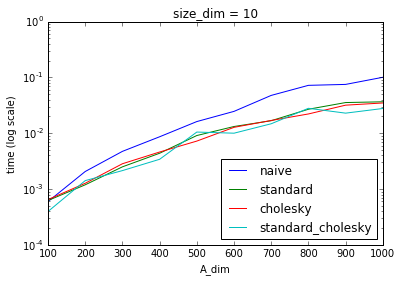

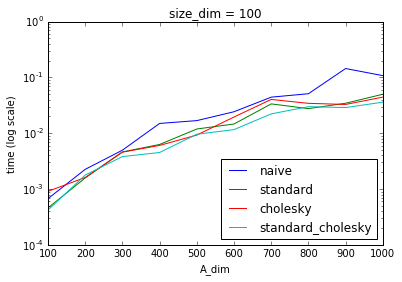

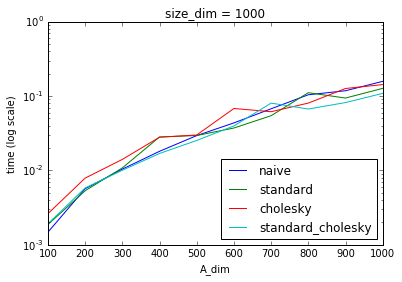

In [14]:
methods = ['naive', 'standard', 'cholesky', 'standard_cholesky']

for size_dim in b_sizes:
    graphs = [times[size_dim][method] for method in methods]
    print_graph(A_sizes, 'A_dim', graphs, methods, 'size_dim = ' + str(size_dim))

In [17]:
%%capture

times_fixed = {
    'naive' : {10 : [], 100 : [], 500: [], 1000 : []},
    'standard' : {10 : [], 100 : [], 500 : [], 1000 : []},
    'cholesky' : {10 : [], 100 : [], 500: [], 1000 : []},
    'standard_cholesky' : {10 : [], 100 : [], 500: [], 1000 : []},
}

sizes_dim = [10, 100, 500, 1000]
A_size = 500
for right_size in sizes_dim:
    X = np.random.rand(A_size, A_size)
    A = np.dot(X, X.T)
    B = np.random.rand(A_size, right_size)

    res = %timeit -o naive_solve(A, B)
    times_fixed['naive'][right_size].append(res.best)

    res = %timeit -o standard_solve(A, B)
    times_fixed['standard'][right_size].append(res.best)

    res = %timeit -o cholesky_solve(A, B)
    times_fixed['cholesky'][right_size].append(res.best)

    res = %timeit -o standard_cholesky_solve(A, B)
    times_fixed['standard_cholesky'][right_size].append(res.best)

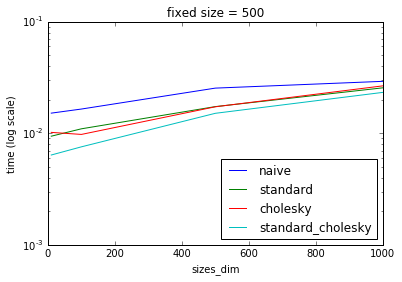

In [18]:
methods = ['naive', 'standard', 'cholesky', 'standard_cholesky']

graphs = [[times_fixed[method][size_dim] for size_dim in sizes_dim] for method in methods]
print_graph(sizes_dim, 'sizes_dim', graphs, methods, 'fixed size = 500')

Вроде как решение с помощью разложения Холецкого быстрее, но нельзя сказать, что это значительный выигрыш.

**Задание 2.2. Пример: вычисление логарифма плотности многомерного нормального распределения (3 балла)**

Случайная величина $\vec{x}\in\mathbb{R}^D$ имеет многомерное нормальное распределение, если её плотность может быть представлена как
$$
p(\vec{x}) = \mathcal{N}(\vec{x}|\vec{\mu},\Sigma) = \frac{1}{\sqrt{2\pi}^D\sqrt{\det\Sigma}}\exp\left(-\frac{1}{2}(\vec{x}-\vec{\mu})^T\Sigma^{-1}(\vec{x}-\vec{\mu})\right)
$$
Здесь $\vec{\mu}\in\mathbb{R}^D -$ вектор мат. ожидания $\vec{x}$, а $\Sigma\in\mathbb{R}^{D{\times}D} -$ матрица ковариации.

С помощью матричных разложений реализуйте алгоритм вычисления логарифма нормальной плотности для набора векторов $X = \{\vec{x}_1,\dots,\vec{x}_N\}$ для заданных $\vec{\mu}$ и $\Sigma$.

Используем разложение Холецкого для матрицы $S$, то есть $S = L^T L$, где $L$ верхнетреугольная. С помощью него обращаем матрицу $S$ через обращение верхнетреугольной матрицы $L$, а именно $S^{-1} = L^{-1}L^{-T}.$ Далее для каждого смещенного вектора $x - m$ считаем скалярное произведение с нужными коэффициентами.

In [22]:
def inverse_triangular(matrix, lower=False):
    size = matrix.shape[0]
    E = np.eye(size)
    return sla.solve_triangular(matrix, E, lower=lower)

#Заготовка:
def my_multivariate_normal_logpdf(X, m, S):
    '''
    Ввод
    -----
    X: набор точек, numpy array размера N x D;
    m: вектор средних значений, numpy array длины D;
    S: ковариационная матрицы, numpy array размера D x D.
    
    Вывод
    ------
    res: результат вычислений, numpy array длины N.
    '''
    D = len(m)
    constant = -float(D) / 2 * np.log(2 * np.pi) - 0.5 * np.log(sla.det(S))
    X_minus_mean = X - m
    L = sla.cholesky(S)
    inv_L = inverse_triangular(L)
    inv_S = (inv_L).dot(inv_L.T)
    answers = []
    
    for x in X_minus_mean:
        answers.append(-0.5 * ((x.T).dot((inv_S).dot(x))))
    
    return constant + np.array(answers)

Сгенерируйте выборку из нормального распределения со случайными параметрами для небольшого $D$ с помощью функции `scipy.stats.multivariate_normal.rvs` и сравните на этой выборке результат работы вашего алгоритма с результатом стандартной функции `scipy.stats.multivariate_normal.logpdf`

In [23]:
from scipy.stats import multivariate_normal as m_n

def get_normal_vectors(D, X_size):
    L = np.random.rand(D, D) 
    S = np.dot(L, L.T) + np.identity(D)
    mean = np.array(np.random.rand(1, D))
    mean = mean[0]
    X = np.array([m_n.rvs(mean=mean.T, cov=S) for i in range(X_size)])
    return S, mean, X

Замерьте время работы вашего алгоритма и функции `scipy.stats.multivariate_normal.logpdf` для различных значений $D$. Постарайтесь добиться, чтобы ваш алгоритм выигрывал по скорости у стандартной функции.

In [25]:
import time

print ('big size of X')

np_times = {1000: [], 1500: []}
my_times = {1000: [], 1500: []}

for D in [150, 200, 250, 300, 400]:
    for X_size in [1000, 1500]:
        S, mean, X = get_normal_vectors(D, X_size)
        print ('D, X_size = ' + str(D) + ', '+ str(X_size))
        np_start = time.time()
        m_n_result = m_n.logpdf(X, mean, S)
        np_finish = time.time()
        print ('numpy logpdf: ' + str(np_finish - np_start))
        np_times[X_size].append(np_finish - np_start)
        
        my_start = time.time()
        my_result = my_multivariate_normal_logpdf(X, mean, S)
        my_finish = time.time()
        my_times[X_size].append(my_finish - my_start)
        
        print ('my logpdf:    ' + str(my_finish - my_start))
        print ('\n')

big size of X
D, X_size = 150, 1000
numpy logpdf: 0.00928807258605957
my logpdf:    0.017166614532470703


D, X_size = 150, 1500
numpy logpdf: 0.02758312225341797
my logpdf:    0.10193324089050293


D, X_size = 200, 1000
numpy logpdf: 0.018979310989379883
my logpdf:    0.02129817008972168


D, X_size = 200, 1500
numpy logpdf: 0.030392169952392578
my logpdf:    0.0284268856048584


D, X_size = 250, 1000
numpy logpdf: 0.030130863189697266
my logpdf:    0.026326894760131836


D, X_size = 250, 1500
numpy logpdf: 0.04265427589416504
my logpdf:    0.04977083206176758


D, X_size = 300, 1000
numpy logpdf: 0.03463172912597656
my logpdf:    0.02763199806213379


D, X_size = 300, 1500
numpy logpdf: 0.109283447265625
my logpdf:    0.19443440437316895


D, X_size = 400, 1000
numpy logpdf: 0.06344437599182129
my logpdf:    0.04360699653625488


D, X_size = 400, 1500
numpy logpdf: 0.06846022605895996
my logpdf:    0.057836055755615234




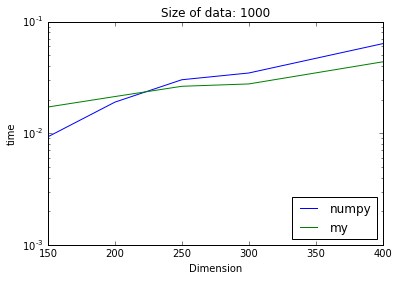

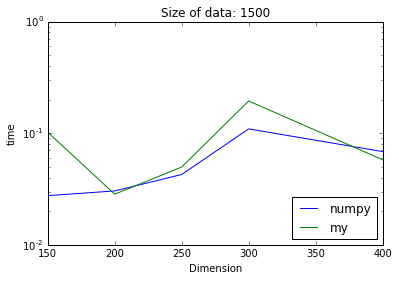

In [30]:
D_sizes = [150, 200, 250, 300, 400]
for X_size in [1000, 1500]:
    plt.semilogy(D_sizes, np_times[X_size], label='numpy')
    plt.semilogy(D_sizes, my_times[X_size], label='my')
    plt.xlabel('Dimension')
    plt.ylabel('time')
    plt.legend(loc='lower right')
    plt.title('Size of data: ' + str(X_size))
    plt.show()

In [32]:
print ('big dimension')
        
np_times = {300: [], 600: [], 1000: []}
my_times = {300: [], 600: [], 1000: []}

for D in [300, 600, 1000]:
    for X_size in [10, 20, 50, 100, 150]:
        S, mean, X = get_normal_vectors(D, X_size)
        print ('D, X_size = ' + str(D) + ', '+ str(X_size))
        np_start = time.time()
        m_n_result = m_n.logpdf(X, mean, S)
        np_finish = time.time()
        print ('numpy logpdf: ' + str(np_finish - np_start))

        my_start = time.time()
        my_result = my_multivariate_normal_logpdf(X, mean, S)
        my_finish = time.time()
        
        np_times[D].append(np_finish - np_start)
        my_times[D].append(my_finish - my_start)
        print ('my logpdf:    ' + str(my_finish - my_start))

        print ('\n')

big dimension
D, X_size = 300, 10
numpy logpdf: 0.028333187103271484
my logpdf:    0.0062944889068603516


D, X_size = 300, 20
numpy logpdf: 0.027643680572509766
my logpdf:    0.006491899490356445


D, X_size = 300, 50
numpy logpdf: 0.02927565574645996
my logpdf:    0.007562160491943359


D, X_size = 300, 100
numpy logpdf: 0.02954387664794922
my logpdf:    0.03300619125366211


D, X_size = 300, 150
numpy logpdf: 0.04428863525390625
my logpdf:    0.010456562042236328


D, X_size = 600, 10
numpy logpdf: 0.12849950790405273
my logpdf:    0.06738448143005371


D, X_size = 600, 20
numpy logpdf: 0.3911740779876709
my logpdf:    0.08024239540100098


D, X_size = 600, 50
numpy logpdf: 0.11961555480957031
my logpdf:    0.038408756256103516


D, X_size = 600, 100
numpy logpdf: 0.3005063533782959
my logpdf:    0.2964804172515869


D, X_size = 600, 150
numpy logpdf: 0.23916888236999512
my logpdf:    0.3521537780761719


D, X_size = 1000, 10
numpy logpdf: 0.7261962890625
my logpdf:    0.23085761070

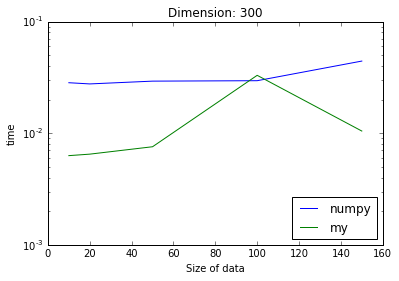

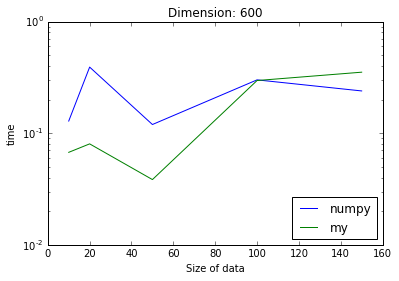

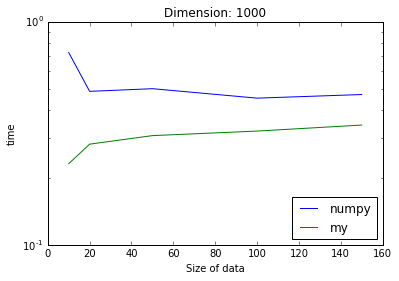

In [36]:
D_sizes = [300, 600, 1000]
X_sizes = [10, 20, 50, 100, 150]
for D in D_sizes:
    plt.semilogy(X_sizes, np_times[D], label='numpy')
    plt.semilogy(X_sizes, my_times[D], label='my')
    plt.xlabel('Size of data')
    plt.ylabel('time')
    plt.legend(loc='lower right')
    plt.title('Dimension: ' + str(D))
    plt.show()

При большой размерности вектора и небольшой выборке моя реализация быстрее, а также при размере выборки хотя бы 200, но это неточно.

В задаче будут оцениваться:
- удалось ли вам обогнать библиотечную функцию;
- использованы ли вы матричные разложения (или просто обратили матрицу:))
- наличие дополнительных оптимизаций

## Часть 3. Разреженные матрицы

Матрица называется разреженной, если в ней мало ненулевых элементов.

Например, если в матрице $n\times n$ порядка $O(n)$ ненулевых элементов, она является разреженной.

Зачастую размерность разреженных матриц, возникающих в реальных задачах, так велика, что хранить её в памяти вместе с нулями - непозволительная роскошь. Есть несколько экономичных методов хранения:

- `Dictionary of Keys` (`DOK`) - словарь `(i,j):element`. 

    $\color{green}{\oplus}$ быстрое добавление элементов с произвольными индексами,
  
    $\color{red}{\ominus}$ любые другие операции будут производиться медленно.


- `List of Lists` (`LIL`) - матрица хранится построчно: в виде двух массивов `[l_1,...,l_s]` и `[v_1,...v_s]`, где `l_i` - список номеров столбцов, в которых в i-й строке находится ненулевой элемент, а `v_i` - список соответствующих значений. В целом, подходит для создания в высокой степени разреженной матрицы. Когда все элементы добавлены, лучше перевести в формат `CSR` или `CSC`.

    $\color{green}{\oplus}$ добавление за линейное время, 
    
    $\color{green}{\oplus}$ быстрый доступ к строкам матрицы, 
    
    $\color{red}{\ominus}$ может требовать слишком много памяти (для создания матриц повышенной плотности используйте `COO`).

    
- `Coordinate List` (`COO`) - хранятся тройки `(row, column, value)`  или три массива \texttt{rows,\ columns,\ values}. При этом тройка с одинаковым началом `(row, column)` может быть не одна; при преобразовании к другому типу значения `value` суммируются.

    $\color{green}{\oplus}$ быстрое добавление новых элементов,
    
    $\color{red}{\ominus}$ для всего остального лучше перевести в другой формат.
    
    
- `Compressed Sparse Row/Column storage` (`CSR/CSC`) - разберём на примере `CSR`. Хранятся три массива: `values`, `indptr` и `indices`. В массиве `values` хранятся все ненулевые элементы матрицы, упорядоченные лексикографически по паре (строка, столбец); `indptr[i]` - индекс начала `i`-й строки, `indices[indptr[i]:indptr[i+1]-1]` - номера столбцов соответствующих элементов.

    $\color{green}{\oplus}$ быстрое выполнение арифметических операций,
    
    $\color{green}{\oplus}$ быстрый доступ к строкам для `CSR` и к столбцам для `CSC`,
    
    $\color{red}{\ominus}$ очень медленный доступ к столбцам для `CSR` и к строкам для `CSC`,
    
    $\color{red}{\ominus}$ медленное добавление/удаление элементов.
  

Главный вывод - не надо один и тот же формат использовать для разных целей!

Вот здесь http://docs.scipy.org/doc/scipy/reference/sparse.html можно посмотреть, как эти возможности реализованы в библиотеке `scipy`.

Вот здесь https://www.cise.ufl.edu/research/sparse/matrices/index.html выложено много разреженных матриц из разнообразных приложений. Что особенно приятно, сайт предоставляет удобный клиент для скачивания, в котором доступен предпросмотр и данные о том, являются ли матрицы симметричными или положительно определёнными.

**Задание 3.0** Загрузите файл `sparse_matrix1.mtx`

In [15]:
import scipy.io as sio

In [16]:
A = sio.mmread('./sparse_matrix1.mtx') # Please type right folder name! 

С помощью следующей функции можно посмотреть, как расположены ненулевые элементы матрицы:

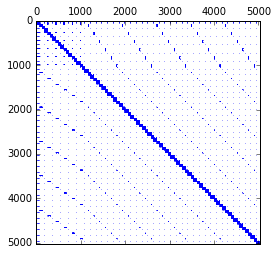

In [178]:
plt.spy(A, marker='.', markersize=0.4)

В каком из пяти форматов хранится матрица? Для ответа на этот вопрос воспользуйтесь функцию `type`.

Сколько в ней ненулевых элементов?

In [182]:
print(type(A))
print(A.nnz)

<class 'scipy.sparse.coo.coo_matrix'>
94026


Посмотрим, сколько времени занимает преобразование между разными форматами.

In [183]:
import pandas as pd
import timeit

A_dok = A.todok()
A_lil = A.tolil()
A_csc = A.tocsc()
A_csr = A.tocsr()

conversion_times = pd.DataFrame(
    index=['COO', 'DOK', 'LIL', 'CSR', 'CSC'],
    columns=['COO', 'DOK', 'LIL', 'CSR', 'CSC'],
    data={
        'COO': [
            np.nan,
            timeit.timeit('A.todok()', 'from __main__ import A', number=100) / 100,
            timeit.timeit('A.tolil()', 'from __main__ import A', number=100) / 100,
            timeit.timeit('A.tocsr()', 'from __main__ import A', number=100) / 100,
            timeit.timeit('A.tocsc()', 'from __main__ import A', number=100) / 100,
               ],
        'DOK': [
            timeit.timeit('A_dok.tocoo()', 'from __main__ import A_dok', number=100) / 100,
            np.nan,
            timeit.timeit('A_dok.tolil()', 'from __main__ import A_dok', number=100) / 100,
            timeit.timeit('A_dok.tocsr()', 'from __main__ import A_dok', number=100) / 100,
            timeit.timeit('A_dok.tocsc()', 'from __main__ import A_dok', number=100) / 100,
               ],
        'LIL': [
            timeit.timeit('A_lil.tocoo()', 'from __main__ import A_lil', number=100) / 100,
            timeit.timeit('A_lil.todok()', 'from __main__ import A_lil', number=100) / 100,
            np.nan,
            timeit.timeit('A_lil.tocsr()', 'from __main__ import A_lil', number=100) / 100,
            timeit.timeit('A_lil.tocsc()', 'from __main__ import A_lil', number=100) / 100,
               ],
        'CSR': [
            timeit.timeit('A_csr.tocoo()', 'from __main__ import A_csr', number=100) / 100,
            timeit.timeit('A_csr.todok()', 'from __main__ import A_csr', number=100) / 100,
            timeit.timeit('A_csr.tolil()', 'from __main__ import A_csr', number=100) / 100,
            np.nan,
            timeit.timeit('A_csr.tocsc()', 'from __main__ import A_csr', number=100) / 100,
               ],
        'CSC': [
            timeit.timeit('A_csc.tocoo()', 'from __main__ import A_csc', number=100) / 100,
            timeit.timeit('A_csc.todok()', 'from __main__ import A_csc', number=100) / 100,
            timeit.timeit('A_csc.tolil()', 'from __main__ import A_csc', number=100) / 100,
            timeit.timeit('A_csc.tocsr()', 'from __main__ import A_csc', number=100) / 100,
            np.nan,
               ],
    }
    )

conversion_times.T

,COO,DOK,LIL,CSR,CSC
COO,NaN,0.060371,0.024743,0.000710,0.000775
DOK,0.108456,NaN,0.122046,0.094265,0.116847
LIL,0.016086,0.083345,NaN,0.013654,0.017219
CSR,0.001302,0.082525,0.033301,NaN,0.000642
CSC,0.001039,0.102148,0.023388,0.000554,NaN


Как вы можете убедиться, быстрее всего преобразования происходят между форматами `COO`, `CSR` и `CSC`, а хуже всего дела обстоят с форматом `DOK`: все преобразования из него занимают чудовищно много времени.

**Задание 3.1 (0,5 балла)** Почему преобразование из формата `LIL` в формат `CSR` занимает такую пропасть времени?

----
Номера столбцов нельзя просто скопировать в indices, нужно еще их предварительно отсортировать, а это занимает довольно много времени.

**Задание 3.2 (1 балл)** Торговая сеть предоставила вам данные о покупках своих клиентов, представляющие собою список из нескольких сотен тысяч чеков (списков покупок). Для того, чтобы определить, какие товары чаще покупают вместе, вы решили построить матрицу, строки и столбцы которой соответствуют различным товарам (предположим, что число различных товаров тоже измеряется сотнями тысяч), а в клетке с "номером" $(g_1, g_2)$ стоит число

$\log_2{\frac{N\cdot c(g_1 \& g_2)}{c(g_1)c(g_2)}},$

где $c(g_i)$ --- количество чеков, содержащих товар $g_i$, $c(g_1 \& g_2)$ --- количество чеков, содержащих оба товара, $N$ --- общее число чеков. В каком формате вы будете создавать эту (очевидно разреженную) матрицу? Почему?

----
Поскольку мы хотим исследовать выгруженные данные, то есть производить различные арифметические операции с эдементами матрицы, которые в дальнейшем не будут изменяться, то самым разумным форматом будет CSR или CSC. То есть первоначальное построение можно сделать в формат COO, а затем перевести в CSR.

Напишите максимально эффективный код, создающий эту матрицу:

In [ ]:
def CreateMatrix(receipts):
    # Your code here
    
    for receipt in receipts:
        # Your code here

**Задание 3.3 (1 балл)** В каком из форматов `LIL` и `COO` умножение на вектор происходит быстрее? Почему? Проведите эксперименты. Можете воспользоваться функцией `scipy.sparse.random` для создания случайных разреженных матриц.

Насколько быстрее с аналогичной задачей будут справляться форматы `CSC` и `CSR`?

----
*Ваш ответ:*

In [11]:
import pandas as pd
from IPython.display import display, HTML
import timeit

D = 2000

for density in [0.001, 0.005, 0.010, 0.050]:
    print('Current density is equal: {0}'.format(density))
    sparse_matrix = sps.random(D, D, density=density)

    rand_vector = sps.random(D, 1, density=1.0);

    sparse_coo = sparse_matrix.tocoo()
    sparse_dok = sparse_matrix.todok()
    sparse_lil = sparse_matrix.tolil()
    sparse_csr = sparse_matrix.tocsr()
    sparse_csc = sparse_matrix.tocsc()

    conversion_times = pd.DataFrame(
        index=['COO', 'DOK', 'LIL', 'CSR', 'CSC'],
        columns=['matrix'],
        data={
            'matrix': [
                timeit.timeit('sparse_coo.multiply(rand_vector)', 'from __main__ import sparse_coo, rand_vector', 
                              number=100) / 100,
                timeit.timeit('sparse_dok.multiply(rand_vector)', 'from __main__ import sparse_dok, rand_vector',
                              number=100) / 100,
                timeit.timeit('sparse_lil.multiply(rand_vector)', 'from __main__ import sparse_lil, rand_vector',
                              number=100) / 100,
                timeit.timeit('sparse_csr.multiply(rand_vector)', 'from __main__ import sparse_csr, rand_vector',
                              number=100) / 100,
                timeit.timeit('sparse_csc.multiply(rand_vector)', 'from __main__ import sparse_csc, rand_vector',
                              number=100) / 100,
                   ],
            }
        )
    display(conversion_times.T)

Current density is equal: 0.001


,COO,DOK,LIL,CSR,CSC
matrix,0.001106,0.004423,0.002788,0.000724,0.000926


Current density is equal: 0.005


,COO,DOK,LIL,CSR,CSC
matrix,0.001873,0.024194,0.005294,0.000961,0.001268


Current density is equal: 0.01


,COO,DOK,LIL,CSR,CSC
matrix,0.002152,0.051054,0.008944,0.001084,0.002027


Current density is equal: 0.05


,COO,DOK,LIL,CSR,CSC
matrix,0.005484,0.289196,0.035399,0.002502,0.005648


Перемножение в формате COO быстрее, чем в LIL, потому что по дефолту все перемножения происходят после предварительного перевода матрицы в csr формат. В предыдущем задании мы видели, что перевод из LIL в CSR медленее, чем из COO в CSR. 
Поэтому и CSC немного медленее CSR из-за дефолтного поведения перемножения.

## Часть 4. Итерационные методы

В этом задании вам предлагается поработать с итеративными методами решения систем уравнений.

Соответствующие функции реализованы в пакете `scipy.sparse.linalg` (http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.linalg.html). Пожалуйста, читайте документацию перед их применением!

В этом задании вам предстоит поближе познакомиться с двумя итеративными методами:

1. **(L)GMRES** (мы настоятельно рекомендуем использовать оптимизированную функцию `scipy.sparse.linalg.lgmres`, даже если вам нужен обыкновенный **GMRES**)

2. **CG** (вызывается функцией `scipy.sparse.linalg.cg`)

*Замечания*:
1. Функции `scipy.sparse.linalg.lgmres` и `scipy.sparse.linalg.cs` устроены так, что могут решать уравнения только с векторной правой частью.
2. Внимательно ознакомьтесь с параметрами (у функции `scipy.sparse.linalg.lgmres` их очень много) и обратите внимание на формат вывода функций.
3. Вы можете захотеть выводить/сохранять что-нибудь после каждой итерации. Для этого существует параметр `callback`: это функция с сигнатурой `callback(xk)`, вызываемая на каждой итерации. Её аргумент `xk` - это текущее приближение $x_k$. Вот пример вызова функции `lgmres`, печатающей норму текущего приближения:

In [18]:
A = np.matrix([[3, 2], [2, 1]])
b = np.array([3, 100])

In [20]:
x = spla.gmres(A, b, callback=lambda xk: print(sla.norm(xk)))

0.877887422501
9.28721695498e-16


Если вы захотите что-нибудь сохранять по ходу дела, логичнее использовать для этого класс. Ниже приводим пример класса, считающего число итераций и выводящего (если указан флаг `disp`) номер каждой итерации на печать, а также запоминающего все промежуточные приближения (не делайте так для больших систем! вам может не хватить памяти):

In [23]:
class iterative_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        self.all_x = [] # Please discard this if you solve large systems!!!
        
    def __call__(self, xk=None):
        self.niter += 1
        self.all_x.append(xk) # Please discard this if you solve large systems!!!
        if self._disp:
            print('iter %3i' % (self.niter))
            
my_counter = iterative_counter() # We need to create an instance of the class

x = spla.gmres(A, b, callback=my_counter)

print(x)
print(my_counter.niter) # Will print total number of iterations

iter   1
iter   2
(array([ 197., -294.]), 0)
2


**Задание 4.1 (3 балла)** Довольно игр! Пора решать большие системы. Загрузите матрицу из файла `large_system.mtx` (она симметричная и положительно определённая) и сгенерируйте случайную правую часть. Решите систему с помощью функции `scipy.sparse.linalg.spsolve` (сильно оптимизированный "точный" решатель) и с помощью итеративных методов `LGMRES` и `CG`. Сравните скорость работы этих методов.

Постарайтесь обогнать функцию `spsolve`, применяя предобуславливание с помощью одной итерации метода Якоби или с помощью неполного LU-разложения. Для ILU постарайтесь подобрать оптимальные значения коэффициентов `fill_factor` и `drop_tol`.

*Замечание.* Если матрица-предобуславливатель $P$ не совсем уж тривиальная, не надо её обращать и умножать на исходную матрицу!

В каждом из итеративных методов можно включить предобуславливание с помощью параметра `M`. В качестве этого параметра нужно передать либо матрицу $P^{-1}$, либо **линейный оператор**, осуществляющий умножение вектора на $P^{-1}$. По понятным причинам второе гораздо правильнее. Делается это следующим образом. Например, если вы хотите ввести предобуславливание с конкретной матрицей $P$ для решения системы $Ax = b$:

In [34]:
A = sio.mmread(r'Pres_Poisson.mtx')
b = np.random.rand(A.shape[0])
P = sps.diags(A.diagonal())

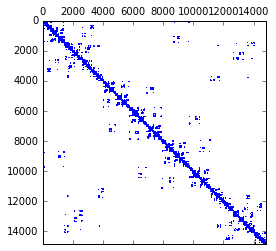

In [40]:
plt.spy(A, marker='.', markersize=0.4)

In [82]:
num_launches = 5

Попробуем метод cg

In [68]:
print(timeit.timeit('spla.cg(A, b)', 'from __main__ import A, b, spla', number=num_launches) / num_launches)

5.189453786006197


А теперь оптимизированный spsolve

In [113]:
print(timeit.timeit('spla.spsolve(A, b)', 'from __main__ import A, b, spla', number=num_launches) / num_launches)

0.9061273086001165


Метод lgmres с предобуславливанием диагональю исходной матрицы.

In [71]:
M = spla.LinearOperator(A.shape, lambda x: spla.spsolve(P, x))
print(timeit.timeit('spla.lgmres(A, b, M=M)', 'from __main__ import A, b, M, spla',
                    number=num_launches) / num_launches)

18.85699620700325


Видим, что данный метод сходится довольно медленно. 

А вот как это работает для неполного LU-разложения:

In [112]:
code = '''\
my_ILU = spla.spilu(A)
M = spla.LinearOperator(A.shape, lambda x: my_ILU.solve(x))
x = spla.lgmres(A, b, M=M)
'''
print(timeit.timeit(code, 'from __main__ import A, b, spla',
                    number=num_launches) / num_launches)

1.2063878409971949


Обратите внимание, что `my_ILU` --- это не просто tuple из четырёх матриц (`spilu` делает разложение вида $P_1AP_2 = LU$, где $P_i$ --- матрицы перестановок). В самом деле, как вы уже, наверное, поняли, в мире больших размерностей иметь матрицу --- это зачастую бесполезное или даже вредное занятие. Гораздо ценнее уметь быстро решать систему с этой матрицей. Поэтому `my_ILU` --- это в первую очередь не разложение (впрочем, матрицы при желании тоже можно извлечь), а оптимизированный решатель `solve`.

In [108]:
grid = {}
num_launches = 5

for fill_factor in np.linspace(5.0, 15.0, num=5):
    for drop_tol in np.linspace(1e-4, 1e-3, num=5):
        dynamic_print('fill_factor={}, drop_tol={}'.format(fill_factor, drop_tol))
        code = '''
my_ILU = spla.spilu(A, fill_factor=fill_factor, drop_tol=drop_tol)
M = spla.LinearOperator(A.shape, lambda x: my_ILU.solve(x))
x = spla.lgmres(A, b, M=M)
'''
        grid[(fill_factor, drop_tol)] = timeit.timeit(code, 'from __main__ import A, b, spla, fill_factor, drop_tol',
                                                      number=num_launches) / num_launches

fill_factor=15.0, drop_tol=0.001

In [110]:
min(grid.items(), key=lambda x: x[1])

((5.0, 0.00032499999999999999), 1.1251384589995723)

Обогнать не получилось, но лучшее параметры $fill\_factor = 5$ и $drop\_tol = 0.000325$

## Часть 5. Матричные дифференцирования

**Задача 5.1 (1 балл)** Пусть $f$ --- функция на множестве квадратных матриц $n\times n$, а $g$ --- функция на множестве симметричных матриц $n\times n$, совпадающая с $f$ на своей области определения. Докажите, что

$$\frac{\partial g}{\partial X} = \frac{\partial f}{\partial X} + \left(\frac{\partial f}{\partial X}\right)^T -
\mathrm{diag}\left(\frac{\partial f}{\partial x_{11}}, \frac{\partial f}{\partial x_{22}},\ldots,
\frac{\partial f}{\partial x_{nn}}\right)$$

$g(X) = g(x_{ij}), i \leq j$, причем $g(x_{11}, \dots x_{ij}(i \leq j), \dots x_{nn}) = f(x_{11}, \dots x_{nn})$. Значит в силу того, что $x_{ij} = x_{ji}$ для $i \neq j$, $x_{ij}$ встречается среди аргументов $f$ два раза, а следовательно: $\frac{\partial g}{x_{ij}} = \frac{\partial f}{x_{ij}} + \frac{\partial f}{x_{ji}}$ для $i \ne j$. Если же $i = j$, то $x_{ij}$ встречается один раз среди аргументов $f$, следовательно  $\frac{\partial g}{\partial x_{ij}} = \frac{\partial f}{\partial  x_{ij}}$.

**Задача 5.2 (0.5 балла)** Найдите производную

$$\frac{\partial\mathrm{tr}\left(AX^2BX^{-T}\right)}{\partial X}$$

**Задача 5.3 (0.5 балла)** Найдите производную

$$\frac{\partial\ln{\det\left(X^TAX\right)}}{\partial X}$$

$$\frac{\partial\ln{\det\left(X^TAX\right)}}{\partial x_{ij}} = tr(\frac{\partial{(\det{X^TAX})}}{\partial X} \cdot \frac{\partial{(X^TAX)}}{\partial{x_{ij}}})
$$
$$
\frac{\partial{(\det{X^TAX})}}{\partial X} = (X^TAX)^{-1}
$$

$$\frac{\partial{(X^TAX)}}{\partial{x_{ij}}} = \frac{\partial{X^T}}{\partial x_{ij}} (AX) + X^T \frac{\partial{(AX)}}{\partial x_{ij}} = E_{ji}(AX) + X^TAE_{ij}$$

Подставляем в первую формулу полученные выражения:
$$\frac{\partial\ln{\det\left(X^TAX\right)}}{\partial x_{ij}} = tr((X^TAX)^{-1}) \cdot (E_{ji}(AX) + X^TAE_{ij}) =
tr(E_{ji}(AX) \cdot X^{-1}A^{-1}X^{-T}) + tr(X^{-1}A^{-1}X^{-T} \cdot X^TAE_{ij}) = tr(E_{ji}X^{-T} + X^{-1}E_{ij}) = tr(2X^{-1}E_{ij}) = 2X^{-T}_{ij}
$$

Отсюда получаем итоговую формулу:
$$\frac{\partial\ln{\det\left(X^TAX\right)}}{\partial X} = 2X^{-T}
$$

**Задача 5.4 (1 балл)** Допустим, что векторы $y_1,\ldots,y_m$ выбраны из многомерного нормального распределения с неизвестными вектором средних $m$ и ковариационной матрицей $\Sigma$. В этом задании вам нужно будет найти оценки максимального правдоподобия $\hat{m}$ и $\hat{\Sigma}$.

Напомним вкратце, что такое оценка максимального правдоподобия в случае непрерывного распределения. Пусть $p(x|\theta_1,\ldots,\theta_k)$ --- функция плотности распределения с неизвестными нам параметрами $\theta_1,\ldots,\theta_k$, а $y_1,\ldots,y_m$ --- выборка из этого распределения. \textit{Функцией правдоподобия} назовём произведение $L(y_1\ldots,y_m|\theta_1,\ldots,\theta_k) := \prod_{j=1}^kp(y_j|\theta_1,\ldots,\theta_k)$; грубо говоря, это произведение показывает, насколько правдоподобно появление данной выборки $y_1,\ldots,y_m$ при данных значениях параметров. В качестве оценки максимального правдоподобия выбирают те значения параметров, при которых функция правдоподобия достигает максимума. При этом как правило удобнее максимизировать не саму функцию правдоподобия, а *логарифмическую функцию правдоподобия* $l(y_1\ldots,y_m|\theta_1,\ldots,\theta_k) = \ln{L(y_1\ldots,y_m|\theta_1,\ldots,\theta_k)}$.

*Подсказка*. Постарайтесь превратить $\sum_i(x_i - m)^T\Sigma^{-1}(x_i - m)$ в функцию от матрицы $X$, столбцами которой являются векторы $x_i$.

Нужно искать максимум логарифма плотности многомерного распределения без учета констант  $-\frac{1}{2} \left ( \sum_i(x_i - m)^T\Sigma^{-1}(x_i - m) \right) - \frac{n}{2}\ln{\det{\Sigma}}$.
Заметим, что сумма из подсказки равна $tr(\left( X - M\right)^{T}\Sigma^{-1}\left(X - M \right))$, где $M = (m, m, \cdots, m)$. 

Обозначим за $A = X - M$. Тогда у нас задача минимизации функции: $tr\left(A^{T}\Sigma^{-1}A\right) + n \cdot \ln{\det{\Sigma}}$. Возьмем производную по $\Sigma$. Производная от логарифма равна $\Sigma^{-T}$.

$tr\left(A^{T}\Sigma^{-1}A\right) = tr\left(\Sigma^{-1}AA^{T}\right)$ по свойству следа матрицы. Обозначим $AA^{T}$ за $B$. 

$$\frac{\partial {tr(\Sigma^{-1}B})}{\partial \Sigma} = tr (\frac{\partial \Sigma^{-1}B}{\partial \Sigma}) = -X^{-T}B^TX^{-T}.$$

Последнюю формулу можно получить, аналогично расписав производную по матричному элементу у обратной матрицы.

Приравниваем к нулю производную по $\Sigma$, получаем: $n \Sigma^{-T} - \Sigma^{-T}B^{T}\Sigma^{-T} = 0 \Rightarrow \Sigma^{T} = B^T \Rightarrow n \cdot \Sigma = B = AA^{T} = (X - M)\cdot (X - M)^{T} = \sum_i(x_i - m)(x_i - m)^{T}$. 
То есть $\Sigma = \frac{1}{n} \sum_i(x_i - m)(x_i - m)^{T}.$

Теперь возьмем производную по всем $m_1, m_2, \cdots, m_n$. Легко видеть, что сюда войдет только сумма из подсказки и производная по $m_i$ будет выглядеть так, если обозначить $\Sigma^{-1}$ за $A$:

$p(x, \Theta)^{'}_{m_i} = a_{k1}(m_1 - \mathbb{E}x_1) + a_{k2}(m_2 - \mathbb{E}x_2) + \cdots + a_{kn}(m_n - \mathbb{E}x_n) + a_{kk}(m_k - \mathbb{E}x_n)$, где $\mathbb{E}x_s$ среднее значение по s-ой координате выборки. Заметим, что если $m = \mathbb{E}x$, то все производные действительно равны $0$. Иначе, если бы это было не так, то матрица $\Sigma^{-1}$ была бы вырожденной, что невозможно.

Ответ: $m = \mathbb{E}x, \Sigma = \frac{1}{n} \sum_i(x_i - m)(x_i - m)^{T}$.